In [2]:
from pygalfitm.VOs import splus

import splusdata

conn = splusdata.connect("gustavo", "asdflkjh")

You have access to internal data


In [3]:
_ = splus.get_splus("test", 52.43008289777575, -33.557141932864596, 200, 'data/', 'outputs/', conn)

File data/test_i.fits.fz already exists. If you mean to replace it then use the argument "overwrite=True".
File data/test_r.fits.fz already exists. If you mean to replace it then use the argument "overwrite=True".
File data/test_g.fits.fz already exists. If you mean to replace it then use the argument "overwrite=True".
finished
finished
finished


In [16]:
from astropy.io import fits

In [90]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.visualization import make_lupton_rgb

In [18]:
f = fits.open("outputs/testss.fits")

In [24]:
print(f)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x171cdd970>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171cdde80>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d2b1c0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d60040>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d60400>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d606a0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d60940>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d60be0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d60e80>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d95100>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x171d95340>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x171d956a0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x171d958e0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x171d60d30>]


In [37]:
from astropy.table import Table

Table.read(f[10])

VERSION,INITFILE,CONSTRNT,FITSECT,CONVBOX,KERNEL,MINSIGMA,NITER,FIRSTCON,LASTCON,NDOF,NFREE,NFIX,NDATA,NMASK,REFWLBAND,LOWDWLBAND,HIGHDWLBAND,CPUTIME_SETUP,CPUTIME_FIT,CPUTIME_TOTAL,CHISQ,CHI2NU,LOGFILE,FLAGS
str33,str514,str514,str514,str514,str514,float32,int32,int32,int32,int32,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,str514,str81
galfitm-1.4.4,outputs/galfit.feedme,none,"[1:200,1:200]","200, 200",,0.0,27,2,2,119989,11,10,120000,0,7670.59,-2912.1,0.0,0.004302,4.935377,5.033668,165255.22,1.3772532,outputs/testss.galfit.02,A-6 A-3 A-4 A-5


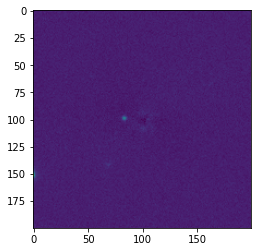

In [34]:
plt.imshow(f[9].data)

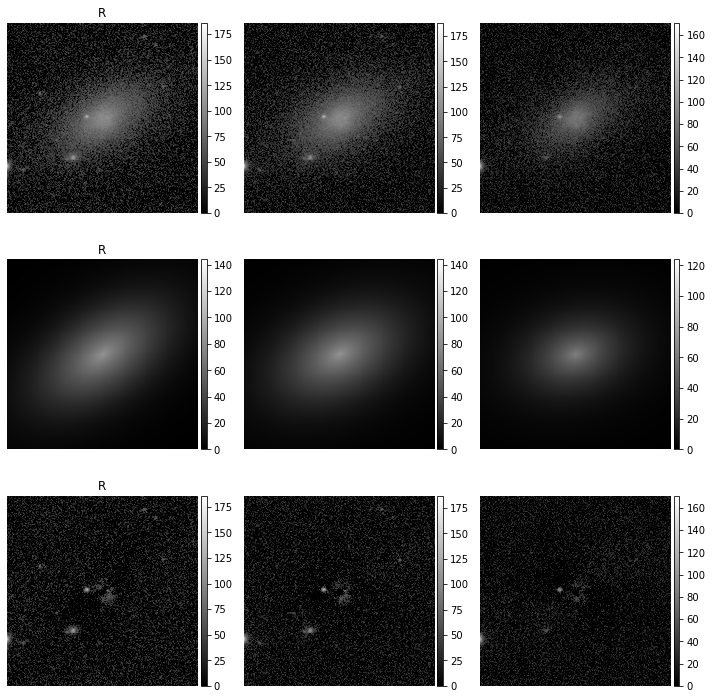

In [157]:
fig = plt.figure(figsize=(10, 10))

bands = 3

for i in range(1, bands * 3 + 1):
    ax = fig.add_subplot(3,3, i)
    im_data = make_lupton_rgb(f[i].data, f[i].data, f[i].data, stretch=1, Q=8)
    im = ax.imshow(im_data, cmap='gray', interpolation='None')
    ax.axis('off')

    if i % bands == 1:
        ax.set_title("R")
    if i <= bands:
        ax.set_ylabel("psf", rotation=0, size='large')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')


fig.tight_layout()
plt.show()

[<AxesSubplot:ylabel='1 RMS'>,
 <Axes:>,
 <AxesSubplot:ylabel='2 RMS'>,
 <Axes:>,
 <AxesSubplot:ylabel='3 RMS'>,
 <Axes:>,
 <AxesSubplot:ylabel='4 RMS'>,
 <Axes:>,
 <AxesSubplot:ylabel='5 RMS'>,
 <Axes:>,
 <AxesSubplot:ylabel='6 RMS'>,
 <Axes:>,
 <AxesSubplot:ylabel='7 RMS'>,
 <Axes:>,
 <AxesSubplot:ylabel='8 RMS'>,
 <Axes:>,
 <AxesSubplot:ylabel='9 RMS'>,
 <Axes:>]

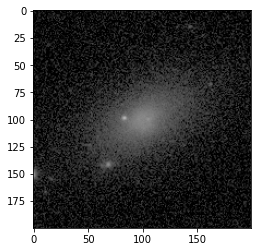

In [135]:
dat = fits.open("data/test_r.fits")[0].data

plt.imshow(make_lupton_rgb(dat, dat, dat, stretch=1, Q=8))

In [130]:
c["A1"].split(",")

['i', 'r', 'g']

In [128]:
c = read_output("outputs/testss.galfit.01.band")

In [123]:
def read_output(filename):
    out = open(filename, "r").read()

    output = {}
    base = True
    current_component = ""

    for i in out.split("\n"):
        i.lstrip().split(" ")[0].replace(")", "")
        
        letter = i.lstrip().split(" ")[0].replace(")", "")
        
        if letter == "" or letter == "#" or len(letter) > 3:
            continue
            
        if letter == "0":
            current_component = i.lstrip().split(" ")[1]
            output[current_component] = {}
            base = False

        if base:
            output[letter] = i.lstrip().split(" ")[1]
        else:
            output[current_component][letter] = i.lstrip().split(" ")[1]

    return output

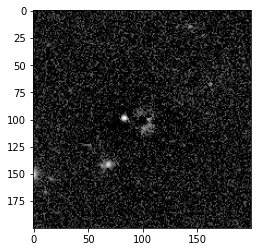

In [83]:
plt.imshow(make_lupton_rgb(f[8].data, f[8].data, f[8].data, stretch=0.5, Q=5))

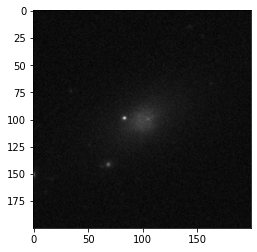

In [72]:
plt.imshow(f[1].data, cmap="gray")